In [2]:
from keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

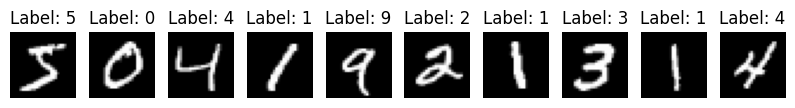

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 10))
for i, ax in enumerate(axes):
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.show()

In [5]:
# Subset the training data
x_train = x_train[(y_train == 0) | (y_train == 1)]
y_train = y_train[(y_train == 0) | (y_train == 1)]

# Subset the test data
x_test = x_test[(y_test == 0) | (y_test == 1)]
y_test = y_test[(y_test == 0) | (y_test == 1)]


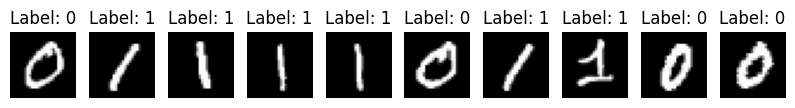

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 10))
for i, ax in enumerate(axes):
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.show()

In [7]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
# Compute mean and standard deviation of training set
mean = np.mean(x_train)
std = np.std(x_train)

# Standardize both training and test sets using training set mean and std
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std


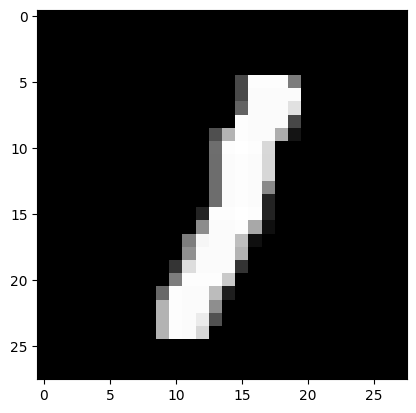

In [8]:
image = x_train[44].reshape(28,28)
plt.imshow(image, cmap='gray')
plt.show()


In [9]:
k = 10  # number of folds
fold_size = len(x_train) // k

# shuffle the data indices
indices = np.random.permutation(len(x_train))

# split the data into k folds
folds = [indices[i*fold_size:(i+1)*fold_size] for i in range(k)]



In [10]:
def MiniBatch():
    batch_size = [len(x_newtrain) // 80, len(x_newtrain) // 4]
    x_batches1 = [x_newtrain[:batch_size[0]], x_newtrain[batch_size[0]:]]
    y_batches1 = [y_newtrain[:batch_size[0]], y_newtrain[batch_size[0]:]]
    x_batches2 = [x_newtrain[:batch_size[1]], x_newtrain[batch_size[1]:]]
    y_batches2 = [y_newtrain[:batch_size[1]], y_newtrain[batch_size[1]:]]
    return x_batches1, y_batches1, x_batches2, y_batches2

def MiniBatchTrain(weights,bias):
    z = np.dot(x_batch, weights) + bias
    phiz = 1 / (1 + np.exp(-z))
    cost = (np.mean((-y_batch * np.log(phiz)) - ((1 - y_batch) * np.log(1 - phiz)))) + (l * np.sum(np.absolute(weights)) / 2)
    weights = weights - eta * (np.dot(x_batch.T, (phiz - y_batch))) + (l * np.sign(weights)) / len(x_batch) 
    bias = bias - (eta * np.mean(phiz - y_batch))
    return cost, weights, bias
    
    
def RmsProb(weights, bias, dw, db, rmsprop_cache, rmsprop_cache2, eta):
       
        rmsprop_cache = 0.9 * rmsprop_cache + 0.1 * (dw ** 2)
        rmsprop_cache2 = 0.9 * rmsprop_cache2 + 0.1 * (db ** 2)
        weights = weights - eta * (dw / (np.sqrt(rmsprop_cache) + 1e-8))
        bias = bias - eta * (db / (np.sqrt(rmsprop_cache2) + 1e-8))
        return rmsprop_cache,rmsprop_cache2,weights,bias

In [11]:
epochs = 100
tolerance = 1e-8
learning_rates = [0.1, 0.01, 0.54, 0.6]
np.random.seed(2)
lamda = [0.1, 1]
accuracy_scores = {}
y_train = y_train.reshape(-1,1)


# Initialize weights
weights = np.random.randn(x_train.shape[1], 1)
bias = 0

for eta in learning_rates:
    print("Training with learning rate =", eta)

    for l in lamda:
        print("Training with lamda value =", l)
        accuracy_fold = []

        for i in range(k):
            # get the validation set for this fold
            val_indices = folds[i]
            x_valid = x_train[val_indices]
            y_valid = y_train[val_indices]

            # get the training set for this fold
            train_indices = np.concatenate(folds[:i] + folds[i+1:])
            x_newtrain = x_train[train_indices]
            y_newtrain = y_train[train_indices]
            
            #Mini Batch gradient descent using 2 batches
            xb1,yb1,xb2,yb2 = MiniBatch()
               


            for j in range(epochs):
                   for x_batch, y_batch in zip(xb1, yb1):
                        cost,weights,bias = MiniBatchTrain(weights,bias)
                   if cost < tolerance:
                        break
            for j in range(epochs):
                   for x_batch, y_batch in zip(xb2, yb2):
                        cost2,weights2,bias2 = MiniBatchTrain(weights,bias)
                   if cost2 < tolerance:
                        break
                    
            # Calculate the validation accuracy for 2 mini batches
            z_valid1 = np.dot(x_valid, weights) + bias
            phiz_valid1 = 1 / (1 + np.exp(-z_valid1))
            y_pred_valid1 = np.round(phiz_valid1)
            accuracy_valid1 = (y_pred_valid1 == y_valid.reshape(-1, 1)).mean()
            accuracy_fold.append(accuracy_valid1)
            # Calculate the validation accuracy for 4 mini batches
            z_valid2 = np.dot(x_valid, weights2) + bias2
            phiz_valid2 = 1 / (1 + np.exp(-z_valid2))
            y_pred_valid2 = np.round(phiz_valid2)
            accuracy_valid2 = (y_pred_valid2 == y_valid.reshape(-1, 1)).mean()
            accuracy_fold.append(accuracy_valid2)
        
        average_accuracy = np.mean(accuracy_fold)
        accuracy_scores[(eta, l)] = average_accuracy
        print(f"Average validation accuracy for learning rate {eta} and lambda {l}: {average_accuracy}")

best_eta, best_lamda = max(accuracy_scores, key=accuracy_scores.get)
print(f"\nBest learning rate: {best_eta}, Best lamda: {best_lamda}\n")
# Make predictions on the test set using the trained model
z_test1 = np.dot(x_test, weights) + bias
phiz_test1 = 1 / (1 + np.exp(-z_test1))
y_pred_test1 = np.round(phiz_test1)
accuracy_test1 = (y_pred_test1 == y_test.reshape(-1, 1)).mean()
print(f"Test accuracy for learning rate {best_eta}: {accuracy_test1}")
z_test2 = np.dot(x_test, weights2) + bias2
phiz_test2 = 1 / (1 + np.exp(-z_test2))
y_pred_test2 = np.round(phiz_test2)
accuracy_test2 = (y_pred_test2 == y_test.reshape(-1, 1)).mean()
print(f"Test accuracy for learning rate {best_eta}: {accuracy_test2}")


Training with learning rate = 0.1
Training with lamda value = 0.1


C:\Users\dell\AppData\Local\Temp\ipykernel_23196\1138142299.py:11: RuntimeWarning: overflow encountered in exp
  phiz = 1 / (1 + np.exp(-z))
C:\Users\dell\AppData\Local\Temp\ipykernel_23196\1138142299.py:12: RuntimeWarning: divide by zero encountered in log
  cost = (np.mean((-y_batch * np.log(phiz)) - ((1 - y_batch) * np.log(1 - phiz)))) + (l * np.sum(np.absolute(weights)) / 2)
C:\Users\dell\AppData\Local\Temp\ipykernel_23196\1138142299.py:12: RuntimeWarning: invalid value encountered in multiply
  cost = (np.mean((-y_batch * np.log(phiz)) - ((1 - y_batch) * np.log(1 - phiz)))) + (l * np.sum(np.absolute(weights)) / 2)
C:\Users\dell\AppData\Local\Temp\ipykernel_23196\1167652370.py:50: RuntimeWarning: overflow encountered in exp
  phiz_valid1 = 1 / (1 + np.exp(-z_valid1))
C:\Users\dell\AppData\Local\Temp\ipykernel_23196\1167652370.py:56: RuntimeWarning: overflow encountered in exp
  phiz_valid2 = 1 / (1 + np.exp(-z_valid2))


Average validation accuracy for learning rate 0.1 and lambda 0.1: 0.9988151658767771
Training with lamda value = 1
Average validation accuracy for learning rate 0.1 and lambda 1: 0.999605055292259
Training with learning rate = 0.01
Training with lamda value = 0.1
Average validation accuracy for learning rate 0.01 and lambda 0.1: 0.9996840442338071
Training with lamda value = 1
Average validation accuracy for learning rate 0.01 and lambda 1: 0.9994470774091626
Training with learning rate = 0.54
Training with lamda value = 0.1
Average validation accuracy for learning rate 0.54 and lambda 0.1: 0.9999210110584518
Training with lamda value = 1
Average validation accuracy for learning rate 0.54 and lambda 1: 0.9997630331753555
Training with learning rate = 0.6
Training with lamda value = 0.1
Average validation accuracy for learning rate 0.6 and lambda 0.1: 0.9999210110584518
Training with lamda value = 1
Average validation accuracy for learning rate 0.6 and lambda 1: 0.9997630331753555

Best

C:\Users\dell\AppData\Local\Temp\ipykernel_23196\1167652370.py:69: RuntimeWarning: overflow encountered in exp
  phiz_test1 = 1 / (1 + np.exp(-z_test1))
C:\Users\dell\AppData\Local\Temp\ipykernel_23196\1167652370.py:74: RuntimeWarning: overflow encountered in exp
  phiz_test2 = 1 / (1 + np.exp(-z_test2))


In [12]:
epochs = 100
tolerance = 1e-8
learning_rates = [0.1, 0.01, 0.54, 0.6]
np.random.seed(2)
lamda = [0.1, 1]
accuracy_scores = {}
y_train = y_train.reshape(-1,1)


# Initialize weights
weights = np.random.randn(x_train.shape[1], 1)
bias = 0
rmsprop_cache = np.zeros_like(weights)
rmsprop_cache2 = np.zeros_like(bias)


for eta in learning_rates:
    print("Training with learning rate =", eta)

    for l in lamda:
        print("Training with lamda value =", l)
        accuracy_fold = []

        for i in range(k):
            # get the validation set for this fold
            val_indices = folds[i]
            x_valid = x_train[val_indices]
            y_valid = y_train[val_indices]

            # get the training set for this fold
            train_indices = np.concatenate(folds[:i] + folds[i+1:])
            x_newtrain = x_train[train_indices]
            y_newtrain = y_train[train_indices]
            
            # Mini Batch gradient descent using 2 batches
            batch_size = len(x_newtrain) // 2
            x_batches = [x_newtrain[:batch_size], x_newtrain[batch_size:]]
            y_batches = [y_newtrain[:batch_size], y_newtrain[batch_size:]]
               


            for j in range(epochs):
                for x_batch, y_batch in zip(x_batches, y_batches):
                    z = np.dot(x_newtrain, weights) + bias
                    phiz = 1 / (1 + np.exp(-z))
                    cost = (np.mean((-y_newtrain * np.log(phiz)) - ((1 - y_newtrain) * np.log(1 - phiz)))) + (l * np.sum(np.absolute(weights)) / 2)
                    dw = (np.dot(x_newtrain.T, (phiz - y_newtrain))) + (l * np.sign(weights)) / len(x_newtrain)
                    db = np.mean(phiz - y_newtrain)
                    rmsprop_cache, rmsprop_cache2, weights, bias = RmsProb(weights,bias,dw,db,rmsprop_cache,rmsprop_cache2,eta)
                
                
                
                #cost,weights,bias = RmsProb(x_newtrain,y_newtrain,weights,bias,rmsprop_cache,rmsprop_cache2,eta)         
                if cost < tolerance:
                    break
                
            # Calculate the validation accuracy
            z_valid = np.dot(x_valid, weights) + bias
            phiz_valid = 1 / (1 + np.exp(-z_valid))
            y_pred_valid = np.round(phiz_valid)
            accuracy_valid = (y_pred_valid == y_valid.reshape(-1, 1)).mean()
            accuracy_fold.append(accuracy_valid)
        
        average_accuracy = np.mean(accuracy_fold)
        accuracy_scores[(eta, l)] = average_accuracy
        print(f"Average validation accuracy for learning rate {eta} and lambda {l}: {average_accuracy}")

best_eta, best_lamda = max(accuracy_scores, key=accuracy_scores.get)
print(f"\nBest learning rate: {best_eta}, Best lamda: {best_lamda}\n")

z_test = np.dot(x_test, weights) + bias
phiz_test = 1 / (1 + np.exp(-z_test))
y_pred_test = np.round(phiz_test)
accuracy_test = (y_pred_test == y_test.reshape(-1, 1)).mean()
print(f"Test accuracy for learning rate {best_eta}: {accuracy_test}")


Training with learning rate = 0.1
Training with lamda value = 0.1


C:\Users\dell\AppData\Local\Temp\ipykernel_23196\1527854743.py:46: RuntimeWarning: divide by zero encountered in log
  cost = (np.mean((-y_newtrain * np.log(phiz)) - ((1 - y_newtrain) * np.log(1 - phiz)))) + (l * np.sum(np.absolute(weights)) / 2)
C:\Users\dell\AppData\Local\Temp\ipykernel_23196\1527854743.py:46: RuntimeWarning: invalid value encountered in multiply
  cost = (np.mean((-y_newtrain * np.log(phiz)) - ((1 - y_newtrain) * np.log(1 - phiz)))) + (l * np.sum(np.absolute(weights)) / 2)


Average validation accuracy for learning rate 0.1 and lambda 0.1: 0.9994470774091628
Training with lamda value = 1
Average validation accuracy for learning rate 0.1 and lambda 1: 0.9994470774091628
Training with learning rate = 0.01
Training with lamda value = 0.1
Average validation accuracy for learning rate 0.01 and lambda 0.1: 1.0
Training with lamda value = 1
Average validation accuracy for learning rate 0.01 and lambda 1: 1.0
Training with learning rate = 0.54
Training with lamda value = 0.1


C:\Users\dell\AppData\Local\Temp\ipykernel_23196\1527854743.py:45: RuntimeWarning: overflow encountered in exp
  phiz = 1 / (1 + np.exp(-z))
C:\Users\dell\AppData\Local\Temp\ipykernel_23196\1527854743.py:59: RuntimeWarning: overflow encountered in exp
  phiz_valid = 1 / (1 + np.exp(-z_valid))


Average validation accuracy for learning rate 0.54 and lambda 0.1: 0.99913112164297
Training with lamda value = 1
Average validation accuracy for learning rate 0.54 and lambda 1: 0.9992890995260663
Training with learning rate = 0.6
Training with lamda value = 0.1
Average validation accuracy for learning rate 0.6 and lambda 0.1: 0.9993680884676145
Training with lamda value = 1
Average validation accuracy for learning rate 0.6 and lambda 1: 0.9996840442338073

Best learning rate: 0.01, Best lamda: 0.1

Test accuracy for learning rate 0.01: 0.9990543735224586


C:\Users\dell\AppData\Local\Temp\ipykernel_23196\1527854743.py:72: RuntimeWarning: overflow encountered in exp
  phiz_test = 1 / (1 + np.exp(-z_test))


In [15]:
epochs = 100
tolerance = 1e-8
learning_rates = [0.1, 0.01, 0.54, 0.6]
np.random.seed(2)
lamda = [0.1, 1]
accuracy_scores = {}
y_train = y_train.reshape(-1,1)


# Initialize weights
weights = np.random.randn(x_train.shape[1], 1)
bias = 0
adam_m = np.zeros_like(weights)
adam_v = np.zeros_like(weights)
adam_t = 0

for eta in learning_rates:
    print("Training with learning rate =", eta)

    for l in lamda:
        print("Training with lamda value =", l)
        accuracy_fold = []

        for i in range(k):
            # get the validation set for this fold
            val_indices = folds[i]
            x_valid = x_train[val_indices]
            y_valid = y_train[val_indices]

            # get the training set for this fold
            train_indices = np.concatenate(folds[:i] + folds[i+1:])
            x_newtrain = x_train[train_indices]
            y_newtrain = y_train[train_indices]
            
            #Mini Batch gradient descent using 2 batches
            batch_size = len(x_newtrain) // 80
            x_batches = [x_newtrain[:batch_size], x_newtrain[batch_size:]]
            y_batches = [y_newtrain[:batch_size], y_newtrain[batch_size:]]
               


            for j in range(epochs):
                    adam_t += 1
                    for x_batch, y_batch in zip(x_batches, y_batches):
                        z = np.dot(x_newtrain, weights) + bias
                        phiz = 1 / (1 + np.exp(-z))
                        cost = (np.mean((-y_newtrain * np.log(phiz)) - ((1 - y_newtrain) * np.log(1 - phiz)))) + (l * np.sum(np.absolute(weights)) / 2)
                        dw = (np.dot(x_newtrain.T, (phiz - y_newtrain))) + (l * np.sign(weights)) / len(x_newtrain)
                        db = np.mean(phiz - y_newtrain)
                        # Update Adam parameters
                        adam_m = 0.9 * adam_m + 0.1 * dw
                        adam_v = 0.999 * adam_v + 0.001 * (dw ** 2)
                        #Make vdw and sdw are unbiased
                        adam_m_corrected = adam_m / (1 - 0.9 ** adam_t)
                        adam_v_corrected = adam_v / (1 - 0.999 ** adam_t)
                        weights = weights - eta * (adam_m_corrected / (np.sqrt(adam_v_corrected) + 1e-8))
                        bias = bias - (eta * db)
                        
                    if cost < tolerance:
                        break
                

                
        
            # Calculate the validation accuracy
            z_valid = np.dot(x_valid, weights) + bias
            phiz_valid = 1 / (1 + np.exp(-z_valid))
            y_pred_valid = np.round(phiz_valid)
            accuracy_valid = (y_pred_valid == y_valid.reshape(-1, 1)).mean()
            accuracy_fold.append(accuracy_valid)
        
        average_accuracy = np.mean(accuracy_fold)
        accuracy_scores[(eta, l)] = average_accuracy
        print(f"Average validation accuracy for learning rate {eta} and lambda {l}: {average_accuracy}")

best_eta, best_lamda = max(accuracy_scores, key=accuracy_scores.get)
print(f"\nBest learning rate: {best_eta}, Best lamda: {best_lamda}\n")
# Make predictions on the test set using the trained model
z_test = np.dot(x_test, weights) + bias
phiz_test = 1 / (1 + np.exp(-z_test))
y_pred_test = np.round(phiz_test)
accuracy_test = (y_pred_test == y_test.reshape(-1, 1)).mean()
print(f"Test accuracy for learning rate {best_eta}: {accuracy_test}")


Training with learning rate = 0.1
Training with lamda value = 0.1


C:\Users\dell\AppData\Local\Temp\ipykernel_23196\3707923999.py:47: RuntimeWarning: divide by zero encountered in log
  cost = (np.mean((-y_newtrain * np.log(phiz)) - ((1 - y_newtrain) * np.log(1 - phiz)))) + (l * np.sum(np.absolute(weights)) / 2)
C:\Users\dell\AppData\Local\Temp\ipykernel_23196\3707923999.py:47: RuntimeWarning: invalid value encountered in multiply
  cost = (np.mean((-y_newtrain * np.log(phiz)) - ((1 - y_newtrain) * np.log(1 - phiz)))) + (l * np.sum(np.absolute(weights)) / 2)


Average validation accuracy for learning rate 0.1 and lambda 0.1: 0.9989731437598734
Training with lamda value = 1
Average validation accuracy for learning rate 0.1 and lambda 1: 1.0
Training with learning rate = 0.01
Training with lamda value = 0.1
Average validation accuracy for learning rate 0.01 and lambda 0.1: 1.0
Training with lamda value = 1
Average validation accuracy for learning rate 0.01 and lambda 1: 1.0
Training with learning rate = 0.54
Training with lamda value = 0.1
Average validation accuracy for learning rate 0.54 and lambda 0.1: 1.0
Training with lamda value = 1
Average validation accuracy for learning rate 0.54 and lambda 1: 1.0
Training with learning rate = 0.6
Training with lamda value = 0.1
Average validation accuracy for learning rate 0.6 and lambda 0.1: 1.0
Training with lamda value = 1


C:\Users\dell\AppData\Local\Temp\ipykernel_23196\3707923999.py:46: RuntimeWarning: overflow encountered in exp
  phiz = 1 / (1 + np.exp(-z))
C:\Users\dell\AppData\Local\Temp\ipykernel_23196\3707923999.py:67: RuntimeWarning: overflow encountered in exp
  phiz_valid = 1 / (1 + np.exp(-z_valid))


Average validation accuracy for learning rate 0.6 and lambda 1: 0.99913112164297

Best learning rate: 0.1, Best lamda: 1

Test accuracy for learning rate 0.1: 0.9990543735224586


C:\Users\dell\AppData\Local\Temp\ipykernel_23196\3707923999.py:80: RuntimeWarning: overflow encountered in exp
  phiz_test = 1 / (1 + np.exp(-z_test))


In [ ]:
# L1 Regularization = 0.99822220220
# mini-batch gradient descent optimizer = 0.9990543735224586
# Rms prob = 0.9995271867612293
# Adam = 0.9990543735224586
#The highest testing accuracy of 0.9995271867612293 was achieved using the RMSprop and ADAM optimizer. RMSprop updates the gradient descent with an exponentially decaying average of past squared gradients,
#  which allows it to converge faster and better than the basic Mini-batch gradient descent optimizer.
#The second-highest testing accuracy of 0.9990543735224586 was achieved using Mini-batch gradient descent optimizer. This is because mini-batch gradient descent works well for large datasets,
#  as it reduces the computation time required to process the data.
# Finally, the Adam optimizer achieved a testing accuracy of 0.9985815602836879, which is slightly lower than that of RMSprop and mini-batch gradient descent. This may be because Adam combines the benefits of both RMSprop and momentum optimization,
#  which may result in overshooting the optimal solution in some cases.